In [280]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ruptures as rpt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from math import *
from numpy.random import *
import seaborn as sns

In [101]:
#!pip install ruptures

     |████████████████████████████████| 991 kB 25.2 MB/s 


In [2]:
from google.colab import files
uploaded = files.upload()

Saving building1.csv to building1.csv


In [275]:
import io
df = pd.read_csv(io.BytesIO(uploaded['building1.csv']))

In [276]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52704 entries, 0 to 52703
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   date                   52704 non-null  object 
 1   fridge                 49022 non-null  float64
 2   washing machine        49022 non-null  float64
 3   television             49022 non-null  float64
 4   electric space heater  49022 non-null  float64
 5   total                  52704 non-null  float64
dtypes: float64(5), object(1)
memory usage: 2.4+ MB


In [277]:
print(df.isnull().sum())

date                        0
fridge                   3682
washing machine          3682
television               3682
electric space heater    3682
total                       0
dtype: int64


Nous avons à notre disposition 5 variables quantitatives, ainsi que la variable 'date' qui est définie ici comme étant une variable catégorielle.
On commence par remplir les données manquante 

In [184]:
df.fillna(df.mean(),inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


In [27]:
df_o=df.copy()

Les date ne sont peut etre pas toute au même fuseau horaire 

In [195]:
df['Datetime']=pd.to_datetime(df['date'])#[0:19])

df.Datetime = pd.to_datetime(df.Datetime, utc=True)
df.Datetime.dt.tz_convert('MST')
df_o=df.copy()

On prend la date comme indice de notre base de données

In [196]:
df = df.set_index(['Datetime'])

# Analyse exploratoire de données:


### Les indicateurs de tendance centrale:

Pour commencer notre analyse descriptive nous allons nous intéresser aux valeurs autour desquelles est concentrée les variables de notre jeu de données. En statistique, il s’agit des indicateurs de $\textbf{tendance centrale}$.

Nous remarquons alors que pour l'ensemble des variables de notre jeu de données, la médiane (50 % des observation sont inférieurs à cette valeur) est largement inférieure à la moyenne, en d'autres termes, nous avons à notre disposition des distributions asymétrique à droite.

In [278]:
df.describe()

,fridge,washing machine,television,electric space heater,total
count,49022.000000,49022.000000,49022.000000,49022.000000,52704.000000
mean,16.361868,13.962696,5.824818,79.435755,149.770743
std,43.392577,147.653543,12.484509,233.993890,315.337037
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,1.000000,1.000000
50%,0.000000,0.000000,0.000000,1.000000,54.557439
75%,1.888889,0.000000,0.000000,1.000000,110.889493
max,3072.000000,2377.521739,238.933333,2060.000000,4056.909091


### Visualisation:

In [281]:
fig = go.Figure()
data_num = df.drop(columns = ["date"])
for col in data_num.columns:
    fig.add_trace(go.Box(x= data_num[col].values, name=data_num[col].name))
fig.show()    

In [284]:
from plotly.subplots import make_subplots
fig = make_subplots(rows=3, cols=2)
trace0 = go.Scatter(x=df["date"], y= df["fridge"],
                    mode='lines',
                    name='Fridge')
trace1 = go.Scatter(x=df["date"], y= df["washing machine"],
                    mode='lines',
                    name='washing machine')
trace2 = go.Scatter(x=df["date"], y= df["television"],
                    mode='lines',
                    name='television')
trace3 = go.Scatter(x=df["date"], y= df["electric space heater"],
                    mode='lines',
                    name='electric space heater')
trace4 = go.Scatter(x=df["date"], y= df["total"],
                    mode='lines',
                    name='total')



fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 2)
fig.append_trace(trace2, 2, 1)
fig.append_trace(trace3, 2, 2)
fig.append_trace(trace4, 3, 1)


fig.show()


Output hidden; open in https://colab.research.google.com to view.

**Remarque :** la variable electric space heater a un comportement saisonnier

Maintenant, on aimerait avoir une idée sur la dinamique des variables au cours du temps, nous allons alors regarder la moyennisation sur une journée des variables ainsi que leur autocorrelation et leurs distribution.

In [292]:
cols=['fridge'	,'washing machine'	,'television'	,'electric space heater'	,'total']

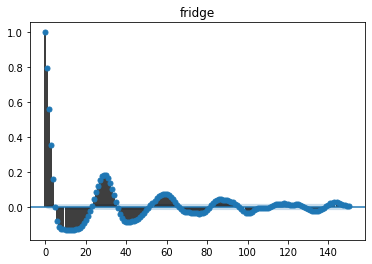

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


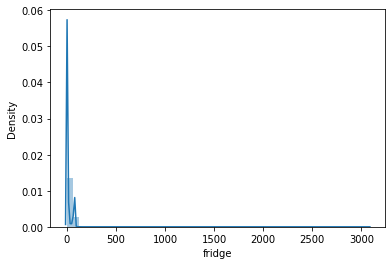

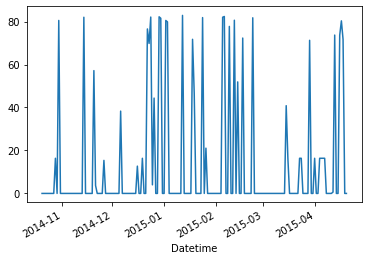

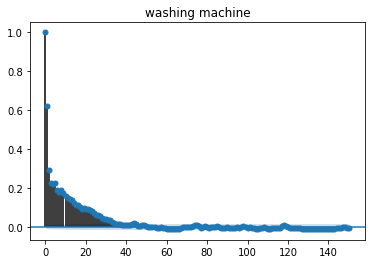

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


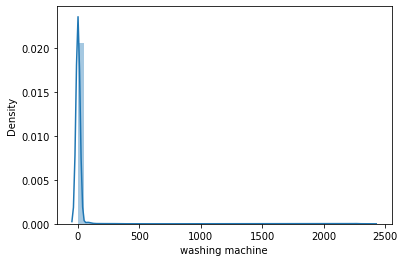

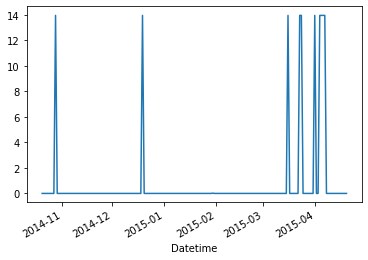

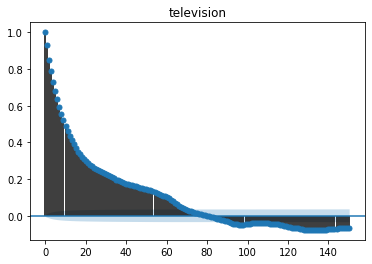

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


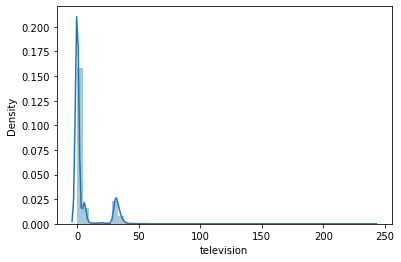

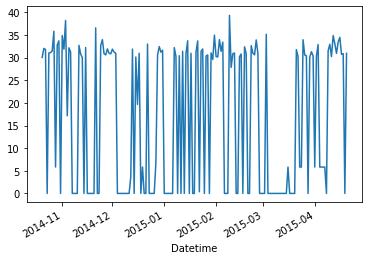

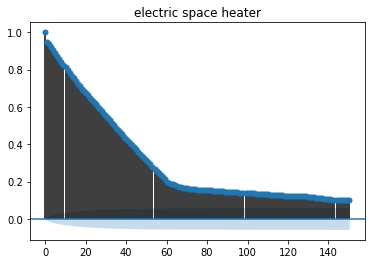

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


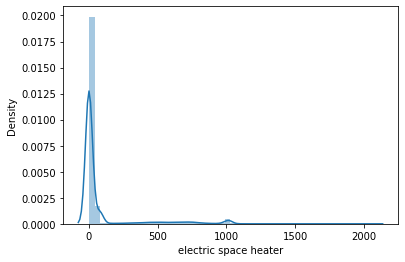

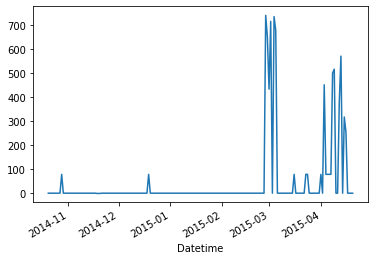

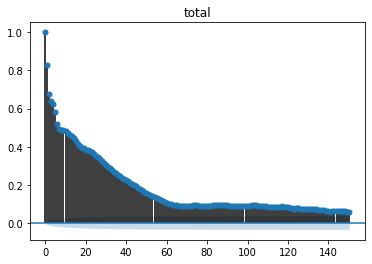

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


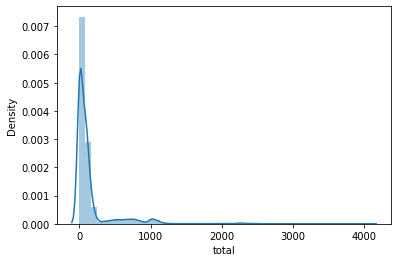

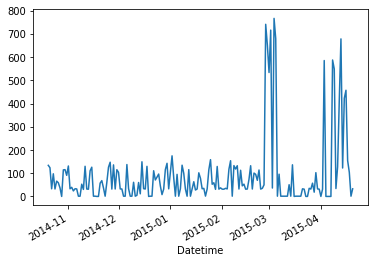

In [220]:
for col in cols:  
  plot_acf(df[col],lags=150,title=col)
  plt.show()
  sns.distplot(df[col])
  plt.show()
  df[col].asfreq('1D').plot()
  #sns.lineplot(x=df_o['Datetime'], y=df_o[col].rolling(10).mean(), color='black', label='rolling mean')
  plt.show()

#Detection de ruptures

Nous allons en premier lieu utiliser la bibliothèque **ruptures** sur les variables moyyenisés sur une journée.

In [269]:
df_or=df.copy()
# df_or.reset_index(inplace=True)
wb={}
for col in cols:
  wb[col]=df_o[col].asfreq('1d')
  #print(col)


dfw=pd.DataFrame(wb)
dfw.reset_index(inplace=True)

model = rpt.Dynp(model="l1")

for col in cols:
  print("#######################################")
  print("Les ruptures de la variable", col)
  print("#######################################")
  y = np.array(dfw[col].tolist())
  model.fit(y)
  breaks = model.predict(n_bkps=4)


  print(breaks)
  for p in breaks:
    if p<len(dfw['Datetime']):
      print(dfw['Datetime'][p])



#######################################
Les ruptures de la variable fridge
#######################################
[70, 75, 175, 180, 183]
2014-12-29 00:00:00+01:00
2015-01-03 00:00:00+01:00
2015-04-13 00:00:00+01:00
2015-04-18 00:00:00+01:00
#######################################
Les ruptures de la variable washing machine
#######################################
[5, 40, 165, 170, 183]
2014-10-25 00:00:00+01:00
2014-11-29 00:00:00+01:00
2015-04-03 00:00:00+01:00
2015-04-08 00:00:00+01:00
#######################################
Les ruptures de la variable television
#######################################
[45, 80, 130, 155, 183]
2014-12-04 00:00:00+01:00
2015-01-08 00:00:00+01:00
2015-02-27 00:00:00+01:00
2015-03-24 00:00:00+01:00
#######################################
Les ruptures de la variable electric space heater
#######################################
[130, 135, 165, 180, 183]
2015-02-27 00:00:00+01:00
2015-03-04 00:00:00+01:00
2015-04-03 00:00:00+01:00
2015-04-18 00:00:00+01:00

On propose la fonction suivante qui nous permet d'avoir les positions d'es ruptures en utilisant un seuil. De ce fait ce n'est pas une méthode trés optimale.
On pourrait pallier à ce probléme en utilisant l'ecart type mobile qui nous informe sur l'ecart entre les valeurs 

In [261]:
def rupture(v,to):
    lst_net=[]
    lst_pos=[]
    t=v.copy()
    for i in range(1,len(v)-1):
        if (((abs (t[i]-t[i-1])>to) & (abs(t[i]-t[i+1])>to))):
            lst_net.append(t[i])
            lst_pos.append(i)
            t[i]=t[i-1]
    
    v_new=t#[x for x in v if x!=-1]
    return(lst_pos)




In [270]:
for col in cols:  
  print("#######################################")
  print("Les ruptures de la variable", col)
  print("#######################################")
  y = np.array(dfw[col].tolist())
  #print(y)
  to=max(y)-min(y)
  pos=rupture(y,to/1.5)
  #print(pos)
  for p in pos:
    print(dfw['Datetime'][p])

#######################################
Les ruptures de la variable fridge
#######################################
2014-10-30 00:00:00+01:00
2014-11-14 00:00:00+01:00
2015-01-12 00:00:00+01:00
2015-01-24 00:00:00+01:00
2015-02-09 00:00:00+01:00
2015-02-12 00:00:00+01:00
2015-02-17 00:00:00+01:00
2015-02-23 00:00:00+01:00
2015-03-29 00:00:00+01:00
2015-04-13 00:00:00+01:00
#######################################
Les ruptures de la variable washing machine
#######################################
2014-10-28 00:00:00+01:00
2014-12-19 00:00:00+01:00
2015-03-16 00:00:00+01:00
2015-04-01 00:00:00+01:00
#######################################
Les ruptures de la variable television
#######################################
2014-10-23 00:00:00+01:00
2014-10-28 00:00:00+01:00
2014-10-31 00:00:00+01:00
2014-11-14 00:00:00+01:00
2014-11-21 00:00:00+01:00
2014-12-13 00:00:00+01:00
2014-12-22 00:00:00+01:00
2015-01-09 00:00:00+01:00
2015-01-11 00:00:00+01:00
2015-01-13 00:00:00+01:00
2015-01-16 00:00:0